## 1.0 Code Setup

1.1 Importing Databases

In [12]:
import influxdb
from datetime import datetime
import pandas as pd
import iso8601
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

ModuleNotFoundError: No module named 'iso8601'

In [ ]:
print("InfluxDB client imported successfully.")

InfluxDB client imported successfully.


1.2 Connecting to InfluxDB for LLL Data

In [ ]:
# Connecting to influxDB
HOST = 'influx.linklab.virginia.edu'
PORT = 443
USERNAME = 'sahbf24'
PASSWORD = 'raighee7Ahpheej3eud2sheob7seey7'
DATABASE = 'gateway-generic'

client = influxdb.InfluxDBClient(HOST, PORT, USERNAME, PASSWORD, DATABASE, ssl=True, verify_ssl=True)

In [ ]:
# testing connection
result = client.query('SELECT value FROM voc_ppb ORDER BY time DESC LIMIT 1 ;')
print(result)

ResultSet({'('voc_ppb', None)': [{'time': '2025-10-28T18:18:16.520000Z', 'value': 78.0}]})


## 2.0 Understanding Energy Data

2.1 Showing all available tags for "energy_kWh", which is the recommended measurement based on https://infrastructure.linklab.virginia.edu/linklabcloud/index.html

In [ ]:
result = client.query('SHOW TAG KEYS FROM "energy_kWh"')
print(result)

ResultSet({'('energy_kWh', None)': [{'tagKey': 'account_no'}, {'tagKey': 'apsystems_system_id'}, {'tagKey': 'description'}, {'tagKey': 'details'}, {'tagKey': 'device_class'}, {'tagKey': 'device_id'}, {'tagKey': 'facilities_tag'}, {'tagKey': 'gateway_id'}, {'tagKey': 'location_general'}, {'tagKey': 'location_specific'}, {'tagKey': 'receiver'}, {'tagKey': 'recorder_id'}]})


2.2 Finding available sensors in Olsson 2xx

In [ ]:
result = client.query('SHOW TAG VALUES FROM "energy_kWh" WITH KEY = "device_id"')
points = list(result.get_points())
num_sensors = len(points)
print(f"Number of sensors reporting energy_kWh data: {num_sensors}")

Number of sensors reporting energy_kWh data: 197


In [ ]:
result = client.query('SHOW TAG VALUES FROM "energy_kWh" WITH KEY = "location_specific"')
locations = list(result.get_points())
print("Locations reporting energy_kWh data:")
for location in locations:
    print(location['value'])

Locations reporting energy_kWh data:
200 Olsson
201 Olsson
203 Olsson
206 Olsson
208 Olsson
210 Olsson
211 Olsson
213 Olsson
217 Olsson
218 Olsson
219 Olsson
225 Olsson
229 Olsson
240 Olsson
241 Olsson
243 Olsson
245 Olsson
247 Olsson
249 Olsson
251 Olsson
253 Olsson
255 Olsson
256 Olsson
257 Olsson
259 Olsson
260 Olsson
261 Olsson
263 Olsson
265 Olsson
269 Olsson
270 Olsson
271 Olsson
273 Olsson
274 Olsson
276 Olsson
277 Olsson
279 Olsson
281 Olsson
283 Olsson
285 Olsson
286 Olsson
2nd Floor Olsson
Home
Roof


Import Polygon Floorplan Model


1. Loading geometry and energy data...
2. Data merged successfully. 38 rooms processed.
3. Generating and saving map...
Map successfully generated and saved to spatial_energy_map.png


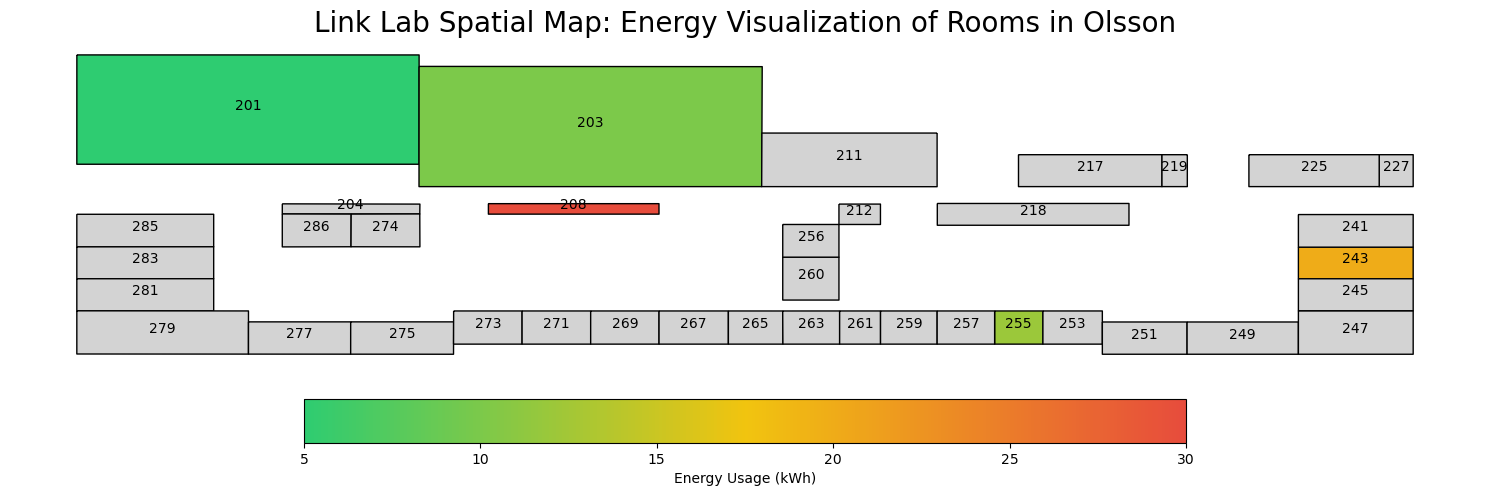

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

spatial_map = "LLFloorplan.gpkg"
energy_csv = "TrialEnergyCSV.csv"
Room_ID_col = "Room_ID"
Energy_col = "Energy"
OUTPUT_MAP_FILE = 'spatial_energy_map.png'

# Load Data and Geometry
print("1. Loading geometry and energy data...")
try:
    energy_df = pd.read_csv(energy_csv) 
    floorplan_gdf = gpd.read_file(spatial_map)
    
except Exception as e:
    print(f"ERROR: Could not load one of the files. Check file names, paths, and extensions.")
    print(f"Details: {e}")
    exit()

# Data Merge
# Merges geometry (from GPKG) with the energy values (from CSV) using the common Room_ID column
merged_gdf = floorplan_gdf.merge(
    energy_df,
    on=Room_ID_col, 
    how='left' 
)
print(f"2. Data merged successfully. {len(merged_gdf)} rooms processed.")

# Define Color Ramp (Green=Low Energy, Red=High Energy)
cmap = LinearSegmentedColormap.from_list(
    'EnergyRamp',
    ['#2ecc71', '#f1c40f', '#e74c3c'], # Green (Low) -> Yellow (Mid) -> Red (High)
    N=256
)

# Generate the Map
print("3. Generating and saving map...")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Plot the merged GeoDataFrame, coloring based on the Energy_col
merged_gdf.plot(
    column=Energy_col, 
    cmap=cmap,
    linewidth=1,
    ax=ax,
    edgecolor='black', 
    legend=True,
    missing_kwds={"color": "lightgrey", "label": "No Data"}, 
    legend_kwds={
        'label': f"{Energy_col} Usage (kWh)",
        'orientation': "horizontal",
        'shrink': .6,
        'pad': 0.02
    }
)

# Add Room Labels
for idx, row in merged_gdf.iterrows():
    # Use the Room_ID_col for the label text but removes Olsson for space
    try:
        ax.annotate(
            str(row[Room_ID_col]).replace('Olsson', '').strip(), 
            xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
            horizontalalignment='center',
            fontsize=10,
            color='black'
        )
    except Exception:
        continue


# Final Polish and Save
ax.set_title(f'Link Lab Spatial Map: {Energy_col} Visualization of Rooms in Olsson', fontsize=20)
ax.set_axis_off() 
plt.tight_layout()
plt.savefig(OUTPUT_MAP_FILE, dpi=300)
print(f"Map successfully generated and saved to {OUTPUT_MAP_FILE}")
